In [1]:
# Opening the text file having report of all the companies
with open(r'C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app\combined_document.txt', encoding='utf-8') as file:
    docs = file.read()

In [2]:
import re

single_sentences = re.split(r'(?<=[.?!])\s+', docs)
print (f"{len(single_sentences)} sentences were found")

58518 sentences were found


In [3]:
sentences = [{'sentence': x, 'index':i} for i, x in enumerate(single_sentences)]
sentences[:9]

[{'sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1.',
  'index': 0},
 {'sentence': 'BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995.',
  'index': 1},
 {'sentence': 'These forward-looking statements are based on current expectations and beliefs and involve numerous risks and uncertainties that could cause actual results to differ materially from expectations.',
  'index': 2},
 {'sentence': 'These forward-looking statements speak only as of the date hereof or as of the dates indicated in the statements and should not be relied upon as predictions of future events, as we cannot assure you that the events or circumstances reflected in these statements will be achieved or will occur.',
  'index': 3},
 {'sentence': 'You can identify forward-looking statements by the use of forward-looking terminology including “believes,

In [4]:
def combine_sentences(sentences, buffer_size=1):
    for i in range(len(sentences)):
        
        # This is a string which will hold the sentences which are joined
        combined_sentence= ''
        
        # Add sentences before the current one, based on the buffer size
        for j in range(i-buffer_size, i):
            # Check if j is not negative
            if j >= 0:
                # Add the sentence at index j to the combined sentence string
                combined_sentence += sentences[j]['sentence'] + ' '
        
        # Add the current sentence
        combined_sentence += sentences[i]['sentence']
        
        # Add the sentences after the current one, based on buffer size
        for j in range(i+1, i+1+buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' '+ sentences[j]['sentence']
        
        #Add the whole thing to the dict
        #Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence
        
    return sentences

sentences = combine_sentences(sentences)

In [5]:
sentences[:5]

[{'sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1.',
  'index': 0,
  'combined_sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1. BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995.'},
 {'sentence': 'BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995.',
  'index': 1,
  'combined_sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1. BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995. These forward-looking statements are based on current expectations and beliefs and involve numerous risks a

In [11]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [10]:
import os
os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY"

In [8]:
# ✅ Define File Paths
EMBEDDINGS_DIR = r"C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app"
EMBEDDINGS_FILE = os.path.join(EMBEDDINGS_DIR, "embeddings.npy")
METADATA_FILE = os.path.join(EMBEDDINGS_DIR, "metadata.json")

In [9]:
sentences_text = [item["combined_sentence"] for item in sentences]  # ✅ Extract text content

In [10]:
sentences_text

['ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1. BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995.',
 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1. BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995. These forward-looking statements are based on current expectations and beliefs and involve numerous risks and uncertainties that could cause actual results to differ materially from expectations.',
 'BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995. These forward-looking statements are based on current expectations

In [11]:
import time

# ✅ Define batch size
batch_size = 100  # Adjust batch size if necessary
total_batches = (len(sentences_text) + batch_size - 1) // batch_size  # Calculate total batches
embeddings = []

print(f"📊 Total Batches to Process: {total_batches}")

for i in range(0, len(sentences_text), batch_size):
    batch = sentences_text[i : i + batch_size]  # ✅ Pass list of strings, not dicts
    batch_number = (i // batch_size) + 1  # Calculate batch number
    try:
        print(f"🔹 Processing batch {batch_number}/{total_batches}...")
        batch_embeddings = embedding_model.embed_documents(batch)
        embeddings.extend(batch_embeddings)
        time.sleep(2)  # Prevent rate limiting
    except Exception as e:
        print(f"❌ Error processing batch {batch_number}/{total_batches}: {e}")

📊 Total Batches to Process: 586
🔹 Processing batch 1/586...
🔹 Processing batch 2/586...
🔹 Processing batch 3/586...
🔹 Processing batch 4/586...
🔹 Processing batch 5/586...
🔹 Processing batch 6/586...
🔹 Processing batch 7/586...
🔹 Processing batch 8/586...
🔹 Processing batch 9/586...
🔹 Processing batch 10/586...
🔹 Processing batch 11/586...
🔹 Processing batch 12/586...
🔹 Processing batch 13/586...
🔹 Processing batch 14/586...
🔹 Processing batch 15/586...
🔹 Processing batch 16/586...
🔹 Processing batch 17/586...
🔹 Processing batch 18/586...
🔹 Processing batch 19/586...
🔹 Processing batch 20/586...
🔹 Processing batch 21/586...
🔹 Processing batch 22/586...
🔹 Processing batch 23/586...
🔹 Processing batch 24/586...
🔹 Processing batch 25/586...
🔹 Processing batch 26/586...
🔹 Processing batch 27/586...
🔹 Processing batch 28/586...
🔹 Processing batch 29/586...
🔹 Processing batch 30/586...
🔹 Processing batch 31/586...
🔹 Processing batch 32/586...
🔹 Processing batch 33/586...
🔹 Processing batch 3

🔹 Processing batch 268/586...
🔹 Processing batch 269/586...
🔹 Processing batch 270/586...
🔹 Processing batch 271/586...
🔹 Processing batch 272/586...
🔹 Processing batch 273/586...
🔹 Processing batch 274/586...
🔹 Processing batch 275/586...
🔹 Processing batch 276/586...
🔹 Processing batch 277/586...
🔹 Processing batch 278/586...
🔹 Processing batch 279/586...
🔹 Processing batch 280/586...
🔹 Processing batch 281/586...
🔹 Processing batch 282/586...
🔹 Processing batch 283/586...
🔹 Processing batch 284/586...
🔹 Processing batch 285/586...
🔹 Processing batch 286/586...
🔹 Processing batch 287/586...
🔹 Processing batch 288/586...
🔹 Processing batch 289/586...
🔹 Processing batch 290/586...
🔹 Processing batch 291/586...
🔹 Processing batch 292/586...
🔹 Processing batch 293/586...
🔹 Processing batch 294/586...
🔹 Processing batch 295/586...
🔹 Processing batch 296/586...
🔹 Processing batch 297/586...
🔹 Processing batch 298/586...
🔹 Processing batch 299/586...
🔹 Processing batch 300/586...
🔹 Processi

🔹 Processing batch 533/586...
🔹 Processing batch 534/586...
🔹 Processing batch 535/586...
🔹 Processing batch 536/586...
🔹 Processing batch 537/586...
🔹 Processing batch 538/586...
🔹 Processing batch 539/586...
🔹 Processing batch 540/586...
🔹 Processing batch 541/586...
🔹 Processing batch 542/586...
🔹 Processing batch 543/586...
🔹 Processing batch 544/586...
🔹 Processing batch 545/586...
🔹 Processing batch 546/586...
🔹 Processing batch 547/586...
🔹 Processing batch 548/586...
🔹 Processing batch 549/586...
🔹 Processing batch 550/586...
🔹 Processing batch 551/586...
🔹 Processing batch 552/586...
🔹 Processing batch 553/586...
🔹 Processing batch 554/586...
🔹 Processing batch 555/586...
🔹 Processing batch 556/586...
🔹 Processing batch 557/586...
🔹 Processing batch 558/586...
🔹 Processing batch 559/586...
🔹 Processing batch 560/586...
🔹 Processing batch 561/586...
🔹 Processing batch 562/586...
🔹 Processing batch 563/586...
🔹 Processing batch 564/586...
🔹 Processing batch 565/586...
🔹 Processi

In [12]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [24]:
sentences[:5]

[{'sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1.',
  'index': 0,
  'combined_sentence': 'ID: AMD_Q4 2023.txt\nTable of ContentsPART IITEM 1. BUSINESS Cautionary Statement Regarding Forward-Looking Statements The statements in this report include forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995.',
  'combined_sentence_embedding': [0.024073153734207153,
   -0.009999535977840424,
   -0.04801299422979355,
   -0.005313360132277012,
   0.05646331608295441,
   0.002675223397091031,
   0.0004506631230469793,
   -0.0030479850247502327,
   -0.004426275379955769,
   0.0327039510011673,
   -0.010666527785360813,
   0.029302319511771202,
   -0.032976288348436356,
   0.02302057482302189,
   0.0162621159106493,
   -0.057814907282590866,
   0.032333746552467346,
   0.03643905371427536,
   -0.006424908991903067,
   -0.0306091345846653,
   0.01407260075211525,
   0.058621663600206375,
   0.02013765275478363,
   0.008419464342296124,


In [23]:
import numpy as np
import json
# ✅ Convert to NumPy Array and Save
embeddings_array = np.array(embeddings)
np.save(EMBEDDINGS_FILE, embeddings_array)

# ✅ Save Metadata (Sentence Mappings)
metadata = {"sentences": sentences_text}
with open(METADATA_FILE, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Embeddings saved to {EMBEDDINGS_FILE}")
print(f"✅ Metadata saved to {METADATA_FILE}")

✅ Embeddings saved to C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app\embeddings.npy
✅ Metadata saved to C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app\metadata.json


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i+1]['combined_sentence_embedding']
        
        # Calculating Cosine Similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distnace
        distance = 1 - similarity
        
        distances.append(distance)
        
        sentences[i]['distance_to_next'] = distance
        
    return distances, sentences

In [19]:
distances, sentences = calculate_cosine_distances(sentences)

In [20]:
distances[:5]

[0.00561691645132123,
 0.12459325564550006,
 0.03399119096073755,
 0.14220699865025244,
 0.009316622524262352]

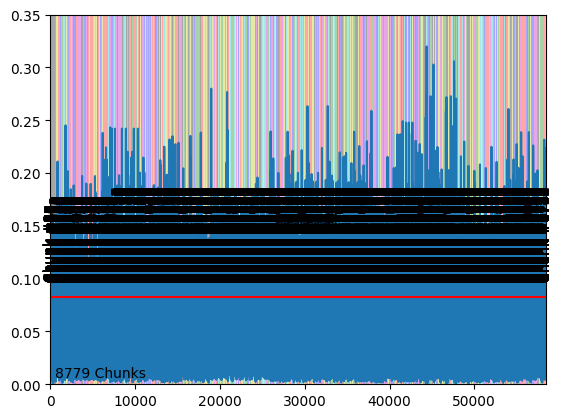

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(distances)
y_upper_bound = 0.35
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

breakpoint_percentile_threshold = 85
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

num_distances_above_threshold = len([x for x in distances if x > breakpoint_distance_threshold])
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_threshold+1} Chunks")

indices_above_threshold = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_threshold):
    start_index = 0 if i == 0 else indices_above_threshold[i-1]
    end_index = breakpoint_index if i < len(indices_above_threshold) - 1 else len(distances)
    
    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.35)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

In [50]:
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_threshold:
    # The end index is one less than the current breakpoint
    end_index = index - 1
    
    #Slice the sentences_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence']for d in group])
    chunks.append(combined_text)
    
    #Update the start index for the next group
    start_index = index
    
# The last group, if any sentences left
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

In [43]:
for i, chunk in enumerate(chunks[2:]):
    buffer = 300
    
    print(f"Chunks #{i}")
    print(chunk[:buffer].strip())
    print("....")
    print(chunk[-buffer:].strip())
    print("\n")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:
# ✅ Save chunks to a text file
text_file_path = "chunks_output_8779.txt"

with open(text_file_path, "w", encoding="utf-8") as text_file:
    for i, chunk in enumerate(chunks):
        text_file.write(f"Chunk {i+1}:\n{chunk}\n\n")

print(f"Chunks successfully saved in {text_file_path}")

Chunks successfully saved in chunks_output_8779.txt


In [1]:
# Opening the text file having report of all the companies
with open(r'C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app\chunks_output_2927.txt', encoding='utf-8') as file:
    docs = file.read()

In [2]:
# STEP 2: Load the text chunks from the provided document
file_path = r"C:\Users\AutomaC\Desktop\AIP\RAG system new companies\Streamlit app\chunks_output_8779.txt"  # Change to your file location
chunks = []

with open(file_path, "r", encoding="utf-8") as file:
    current_chunk = []
    for line in file:
        if line.strip().startswith("Chunk"):  # Detect chunk headers
            if current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
        current_chunk.append(line.strip())

    if current_chunk:  # Add the last chunk
        chunks.append(" ".join(current_chunk))

print(f"Loaded {len(chunks)} chunks from the file.")

Loaded 8779 chunks from the file.
